In [30]:
import numpy as np

data_path = '/home/yigit/Documents/projects/irl_sfm/data/demonstrations/1_person_no_obs/1591503081.npy'
tracks = np.load(data_path, allow_pickle=True, encoding='latin1')
tracks = tracks[:-1]  # last one was not complete, discarding it
num_tracks = len(tracks)
print(num_tracks)


65


In [31]:
min_len = 1000
min_id = -1

for i in range(num_tracks):
    if len(tracks[i]) < min_len:
        min_len = len(tracks[i])
        min_id = i
        
print(f'{min_id}: {min_len}')

6: 246


##### Normalizing the lengths:
Uniformly selecting *desired_len* samples per track

In [32]:
desired_len = min_len
X, Y = np.zeros((num_tracks, desired_len, 5)), np.zeros((num_tracks, desired_len, 2))

for i in range(num_tracks):
    # normalizing the lengths
    len_track = len(tracks[i])
    indices = np.linspace(0, len_track-1, desired_len, dtype=int)  # <desired_len>-many indices are selected uniformly
    x, y = np.zeros((desired_len, 5)), np.zeros((desired_len, 2))
    for new_ind, old_ind in enumerate(indices):
        x[new_ind] = tracks[i][old_ind][:-2]
        y[new_ind] = tracks[i][old_ind][-2:]
    X[i] = x
    Y[i] = y

[Text(0, 0.5, 'cos(angle)'), Text(0.5, 0, 'step')]

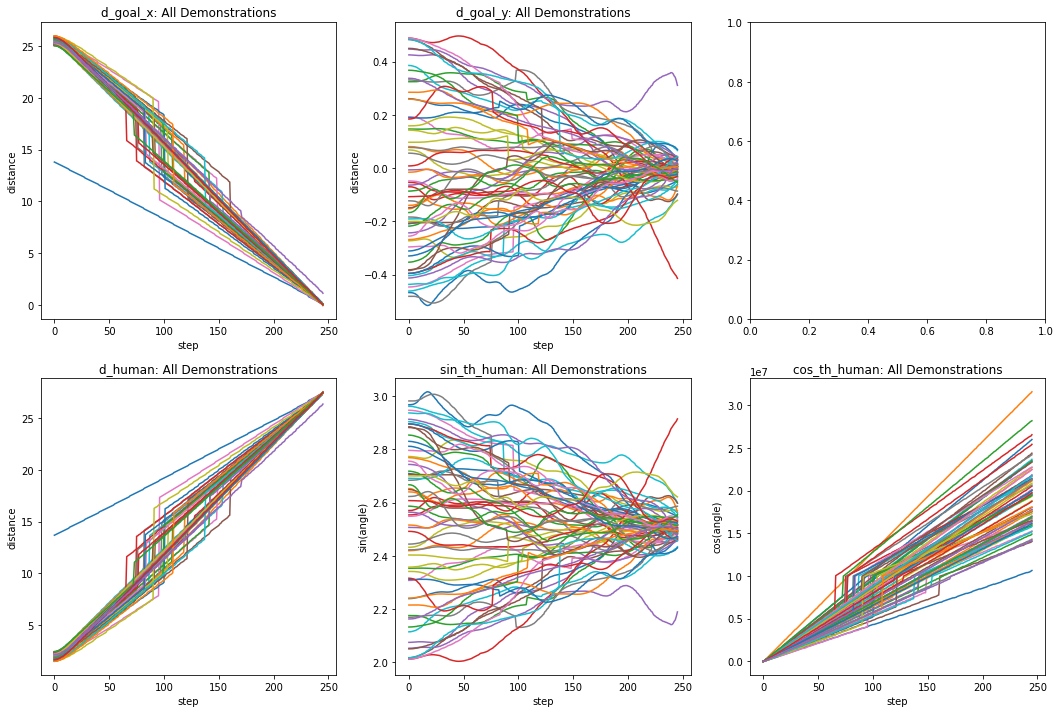

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 12]

fig, axs = plt.subplots(2, 3)
for i in range(num_tracks):
    axs[0, 0].plot(range(desired_len), X[i, :, 1])
axs[0, 0].set_title('d_goal_x: All Demonstrations')
axs[0, 0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[0, 1].plot(range(desired_len), X[i, :, 2])
axs[0, 1].set_title('d_goal_y: All Demonstrations')
axs[0, 1].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[1, 0].plot(range(desired_len), X[i, :, 3])
axs[1, 0].set_title('d_human: All Demonstrations')
axs[1, 0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[1, 1].plot(range(desired_len), X[i, :, 4])
axs[1, 1].set_title('sin_th_human: All Demonstrations')
axs[1, 1].set(xlabel='step', ylabel='sin(angle)')

for i in range(num_tracks):
    axs[1, 2].plot(range(desired_len), X[i, :, 0])
axs[1, 2].set_title('cos_th_human: All Demonstrations')
axs[1, 2].set(xlabel='step', ylabel='cos(angle)')

# for ax in axs.flat:
#     ax.label_outer()

In [34]:
newX, newY = [], []
for i in range(num_tracks):
    keep = True
    for j in range(desired_len-1):
        if np.abs(X[i,j,1] - X[i,j+1,1]) > 1:  # jumps in d_g_x more than 1m
#             print(i)
            keep = False
            break
        elif np.abs(X[i,j,2] - X[i,j+1,2]) > 1:  # jumps in d_h more than 1m
            print(f'{i}: {X[i,j,3]} - {X[i,j+1,3]}')
            keep = False
            break
            
    if X[i, 0, 1] < 20:
        keep = False

    if keep:
        newX.append(X[i])
        newY.append(Y[i])

num_tracks = len(newX)  # removed some tracks
X = np.array(newX)
Y = np.array(newY)
print(X.shape)
print(Y.shape)

(37, 246, 5)
(37, 246, 2)


[Text(0, 0.5, 'distance'), Text(0.5, 0, 'step')]

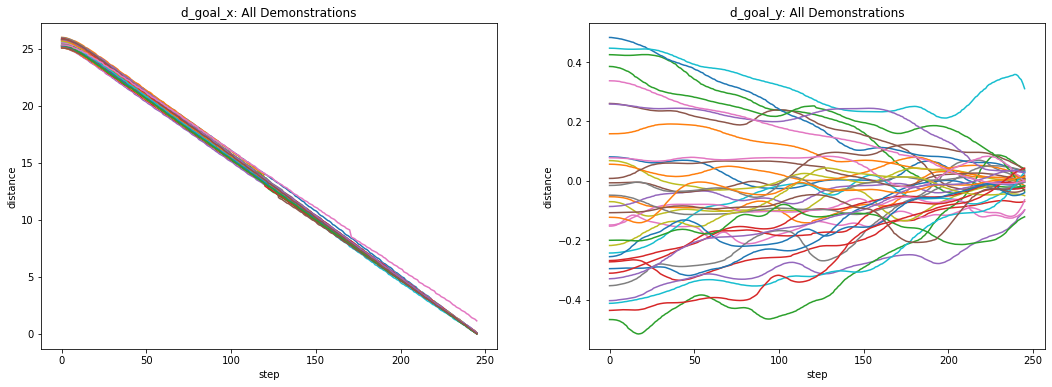

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

fig, axs = plt.subplots(1, 2)
for i in range(num_tracks):
    axs[0].plot(range(desired_len), X[i, :, 1])
axs[0].set_title('d_goal_x: All Demonstrations')
axs[0].set(xlabel='step', ylabel='distance')

for i in range(num_tracks):
    axs[1].plot(range(desired_len), X[i, :, 2])
axs[1].set_title('d_goal_y: All Demonstrations')
axs[1].set(xlabel='step', ylabel='distance')

In [38]:
from sklearn.model_selection import train_test_split

data_path = '/home/yigit/phd/yigit_phd_thesis/cnmp/data/1_person_no_obs/'

x_get_dims = np.array([1,2]) # other dims seem unnecessary
X = X[:, :, x_get_dims]

# reshaping to meet CNMP requirements
X = np.reshape(X, (num_tracks, desired_len, len(x_get_dims)))
Y = np.reshape(Y, (num_tracks, desired_len, 2))

# saving 20% for validation and the 80% for training
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

np.save(data_path+'d_x.npy', np.array(x_train))
np.save(data_path+'d_y.npy', np.array(y_train))
np.save(data_path+'v_d_x.npy', np.array(x_val))
np.save(data_path+'v_d_y.npy', np.array(y_val))